In [1]:
# Retail Sales Dataset Analysis
# Author: Sri Charan Konidina
# Date: 2025-10-11
# Goal: Explore a Kaggle Supermarket Sales dataset and visualize key insights.


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

# Load dataset 
df = pd.read_csv('supermarket_sales.csv')
print("Loaded sales.csv — shape:", df.shape)
df.head(5)


Loaded sales.csv — shape: (1000, 17)


,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Total,Date,Time,Payment,cogs,gross margin percentage,gross income,Rating
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,1/5/2019,13:08,Ewallet,522.83,4.761905,26.1415,9.1
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,3/8/2019,10:29,Cash,76.40,4.761905,3.8200,9.6
2,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,3/3/2019,13:23,Credit card,324.31,4.761905,16.2155,7.4
3,123-19-1176,A,Yangon,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,1/27/2019,20:33,Ewallet,465.76,4.761905,23.2880,8.4
4,373-73-7910,A,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,2/8/2019,10:37,Ewallet,604.17,4.761905,30.2085,5.3


In [8]:
# Show info, nulls, and value counts for product line
print(df.info())
print("\nNull counts:\n", df.isnull().sum())
if 'Product line' in df.columns:
    print("\nTop Product lines:\n", df['Product line'].value_counts().head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Invoice ID               1000 non-null   object 
 1   Branch                   1000 non-null   object 
 2   City                     1000 non-null   object 
 3   Customer type            1000 non-null   object 
 4   Gender                   1000 non-null   object 
 5   Product line             1000 non-null   object 
 6   Unit price               1000 non-null   float64
 7   Quantity                 1000 non-null   int64  
 8   Tax 5%                   1000 non-null   float64
 9   Total                    1000 non-null   float64
 10  Date                     1000 non-null   object 
 11  Time                     1000 non-null   object 
 12  Payment                  1000 non-null   object 
 13  cogs                     1000 non-null   float64
 14  gross margin percentage  

Using numeric column for sales: Total


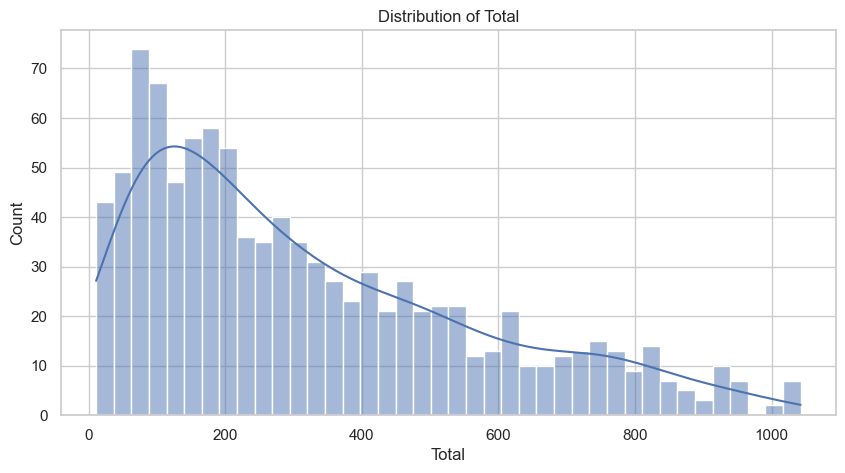

In [9]:
# Try to find the column for total amount
candidates = ['Total', 'total', 'gross income', 'Total Sales', 'TotalAmount', 'Total_price']
num_col = None
for c in candidates:
    if c in df.columns:
        num_col = c
        break
# fallback: try to find numeric columns with large values
if num_col is None:
    numeric = df.select_dtypes(include=[np.number]).columns.tolist()
    print("Numeric columns:", numeric)
    # choose a reasonable numeric column
    num_col = numeric[-1]  # heuristic
print("Using numeric column for sales:", num_col)

plt.figure(figsize=(10,5))
sns.histplot(df[num_col], bins=40, kde=True)
plt.title("Distribution of " + str(num_col))
plt.xlabel(num_col)
plt.show()


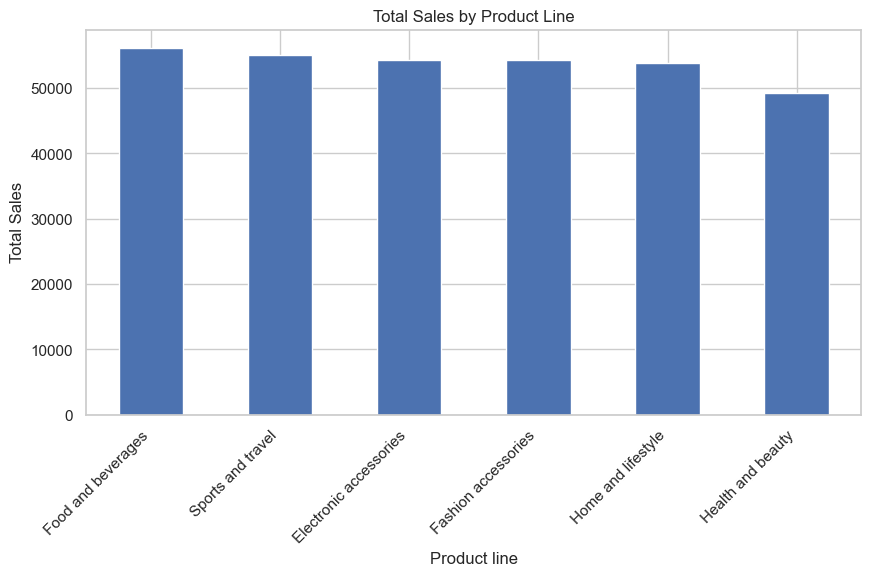

In [10]:
if 'Product line' in df.columns:
    agg = df.groupby('Product line')[num_col].sum().sort_values(ascending=False)
    plt.figure(figsize=(10,5))
    agg.plot(kind='bar')
    plt.title('Total Sales by Product Line')
    plt.ylabel('Total Sales')
    plt.xticks(rotation=45, ha='right')
    plt.show()
else:
    print("Product line column not present; skipping.")


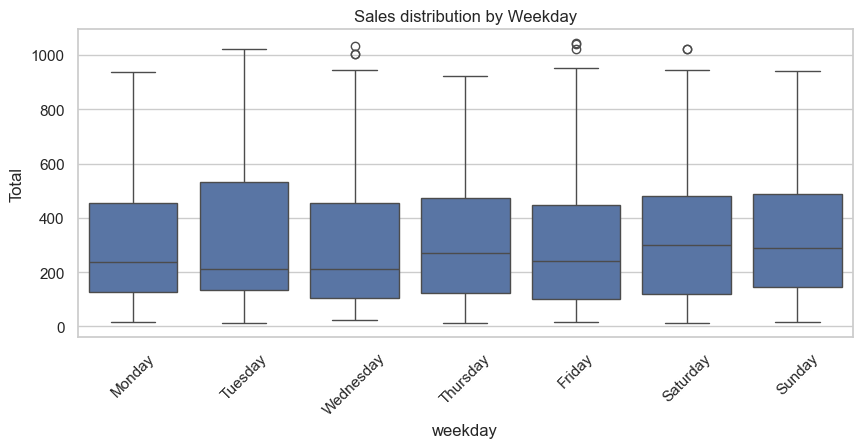

In [11]:
# Trying to parse date/time if present
if 'Date' in df.columns or 'date' in df.columns:
    # normalize column names
    date_col = 'Date' if 'Date' in df.columns else 'date'
    df['Date_parsed'] = pd.to_datetime(df[date_col], errors='coerce')
    if df['Date_parsed'].notna().sum() > 0:
        df['weekday'] = df['Date_parsed'].dt.day_name()
        plt.figure(figsize=(10,4))
        order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
        sns.boxplot(x='weekday', y=num_col, data=df, order=order)
        plt.title('Sales distribution by Weekday')
        plt.xticks(rotation=45)
        plt.show()
    else:
        print("Date column exists but could not parse values.")
else:
    print("No Date column available for weekday analysis.")


In [12]:
from sklearn.ensemble import IsolationForest

# Prepare X — use numeric sales/total column
X = df[[num_col]].fillna(0)
model = IsolationForest(contamination=0.01, random_state=42)
df['anomaly_flag'] = model.fit_predict(X)
anoms = df[df['anomaly_flag'] == -1]
print("Anomalies detected:", len(anoms))
# show top 10 anomalies
anoms_sorted = anoms.sort_values(by=num_col, ascending=False).head(10)
anoms_sorted[[num_col]].head(10)


Anomalies detected: 10


,Total
350,1042.6500
167,1039.2900
557,1034.4600
699,1023.7500
996,1022.4900
792,1022.3850
422,1020.7050
166,1003.5900
357,1002.1200
822,10.6785


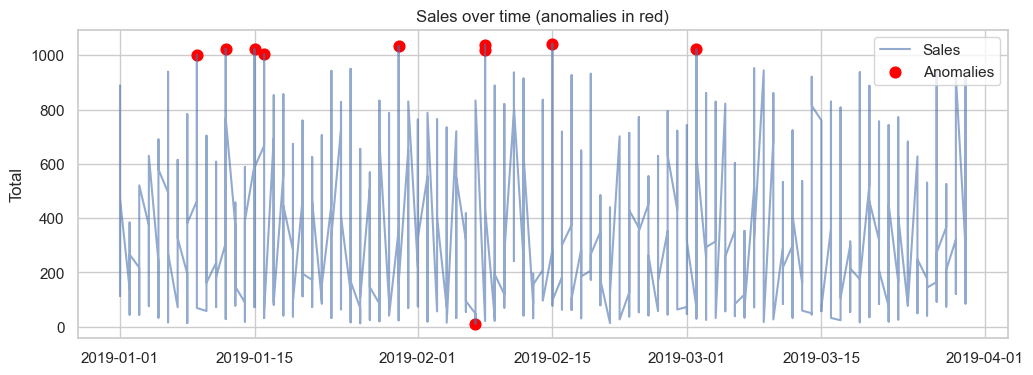

In [13]:
if 'Date_parsed' in df.columns:
    sample = df.sort_values('Date_parsed')
    plt.figure(figsize=(12,4))
    plt.plot(sample['Date_parsed'], sample[num_col], label='Sales', alpha=0.6)
    plt.scatter(sample[sample['anomaly_flag'] == -1]['Date_parsed'],
                sample[sample['anomaly_flag'] == -1][num_col],
                color='red', s=60, label='Anomalies')
    plt.legend()
    plt.title('Sales over time (anomalies in red)')
    plt.ylabel(num_col)
    plt.show()
else:
    print("No Date_parsed — cannot plot anomalies over time.")


In [14]:
from IPython.display import Markdown
Markdown("### Summary\n- Total rows: %d\n- Column used as sales: %s\n- Anomalies detected: %d\n\nNext steps: deeper feature engineering, build a dashboard, try Autoencoder/LSTM for temporal anomalies." % (len(df), num_col, int((df['anomaly_flag']==-1).sum())))


### Summary
- Total rows: 1000
- Column used as sales: Total
- Anomalies detected: 10

Next steps: deeper feature engineering, build a dashboard, try Autoencoder/LSTM for temporal anomalies.